
Starting Figure 2 reproduction with seed=42 and verbose_optimization=False

--- Starting Figure 2 Reproduction Experiment ---

Processing Df_strength = 0.00 (1/30)

Processing Df_strength = 1.21 (2/30)

Processing Df_strength = 2.41 (3/30)

Processing Df_strength = 3.62 (4/30)

Processing Df_strength = 4.83 (5/30)

Processing Df_strength = 6.03 (6/30)

Processing Df_strength = 7.24 (7/30)

Processing Df_strength = 8.45 (8/30)

Processing Df_strength = 9.66 (9/30)

Processing Df_strength = 10.86 (10/30)

Processing Df_strength = 12.07 (11/30)

Processing Df_strength = 13.28 (12/30)

Processing Df_strength = 14.48 (13/30)

Processing Df_strength = 15.69 (14/30)

Processing Df_strength = 16.90 (15/30)

Processing Df_strength = 18.10 (16/30)

Processing Df_strength = 19.31 (17/30)

Processing Df_strength = 20.52 (18/30)

Processing Df_strength = 21.72 (19/30)

Processing Df_strength = 22.93 (20/30)

Processing Df_strength = 24.14 (21/30)

Processing Df_strength = 25.34 (22/30)

Processing

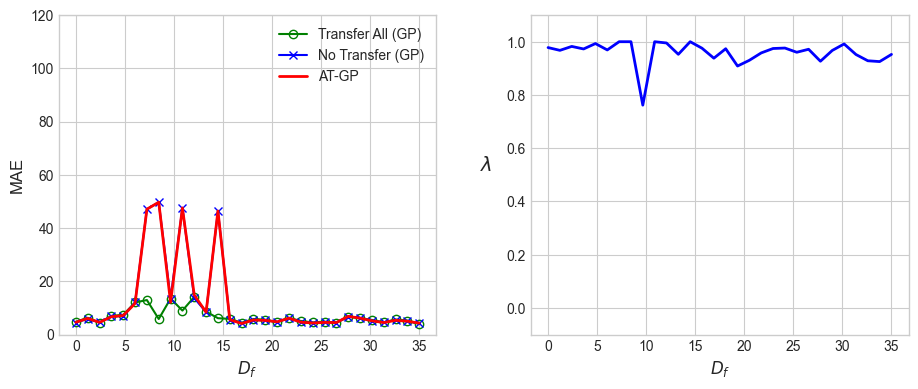


Figure 2 reproduction experiment finished.


In [4]:
# %% [markdown]
# # Adaptive Transfer Learning Implementation
# Authors: Bin Cao, Sinno Jialin Pan, Yu Zhang, Dit-Yan Yeung, Qiang Yang

# %%
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.io import loadmat
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# --- Kernel Function ---
class SquaredExponentialKernel:
    def __init__(self, length_scale=1.0, sigma_f=1.0):
        self.length_scale = length_scale
        self.sigma_f = sigma_f

    def get_params(self):
        return np.array([self.length_scale, self.sigma_f])

    def set_params(self, params):
        self.length_scale = params[0]
        self.sigma_f = params[1]

    def __call__(self, X1, X2):
        if X1.ndim == 1: X1 = X1[:, np.newaxis]
        if X2.ndim == 1: X2 = X2[:, np.newaxis]

        if X1.shape[1] != X2.shape[1]:
            raise ValueError(f"X1 and X2 must have the same number of features. Got {X1.shape[1]} and {X2.shape[1]}")

        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        sqdist = np.clip(sqdist, 0, np.inf) # Ensure non-negative

        return self.sigma_f**2 * np.exp(-0.5 / self.length_scale**2 * sqdist)

# Helper to compute covariance matrix
def calculate_covariance_matrix(X1, X2, kernel_func):
    return kernel_func(X1, X2)

# --- Metrics ---
def nmse(y_true, y_pred):
    y_true_v = np.asarray(y_true).flatten()
    y_pred_v = np.asarray(y_pred).flatten()
    if len(y_true_v) == 0 or len(y_pred_v) == 0: return np.nan
    mse = np.mean((y_true_v - y_pred_v)**2)
    var_true = np.var(y_true_v)
    if var_true < 1e-9: # Avoid division by zero if true values are constant
        return mse if mse > 1e-9 else 0.0
    return mse / var_true

def error_distance(y_true, y_pred): # This is RMSE for 1D output, or mean Euclidean for multi-output
    y_true_v = np.asarray(y_true)
    y_pred_v = np.asarray(y_pred)
    if y_true_v.ndim == 1: y_true_v = y_true_v.reshape(-1,1)
    if y_pred_v.ndim == 1: y_pred_v = y_pred_v.reshape(-1,1)

    if y_true_v.shape[0] == 0 or y_pred_v.shape[0] == 0: return np.nan
    # For 1D output, this is equivalent to RMSE
    return np.mean(np.sqrt(np.sum((y_true_v - y_pred_v)**2, axis=1)))


def mae(y_true, y_pred):
    y_true_v = np.asarray(y_true).flatten()
    y_pred_v = np.asarray(y_pred).flatten()
    if len(y_true_v) == 0 or len(y_pred_v) == 0: return np.nan
    return np.mean(np.abs(y_true_v - y_pred_v))

# --- AT-GP Model (from paper) ---
class ATGP:
    def __init__(self, X_S, y_S, X_T, y_T,
                 initial_length_scale=1.0, initial_sigma_f=1.0,
                 initial_b=1.0, initial_mu=1.0,
                 initial_noise_S_std=0.1, initial_noise_T_std=0.1):
        self.X_S = X_S
        self.y_S = y_S.reshape(-1, 1)
        self.X_T = X_T
        self.y_T = y_T.reshape(-1, 1)

        self._length_scale = initial_length_scale
        self._sigma_f = initial_sigma_f
        self._b = initial_b
        self._mu = initial_mu
        self._noise_S_std = initial_noise_S_std
        self._noise_T_std = initial_noise_T_std

        self.base_kernel = SquaredExponentialKernel(self._length_scale, self._sigma_f)
        self.fitted = False
        self.optimized_params_ = {}

    def _get_params_array(self):
        return np.array([self._length_scale, self._sigma_f, self._b, self._mu,
                         self._noise_S_std, self._noise_T_std])

    def _set_params_from_array(self, params_array):
        self._length_scale = params_array[0]
        self._sigma_f = params_array[1]
        self.base_kernel.set_params(params_array[:2])
        self._b = params_array[2]
        self._mu = params_array[3]
        self._noise_S_std = params_array[4]
        self._noise_T_std = params_array[5]

    def _get_lambda(self, b_param=None, mu_param=None):
        b_to_use = b_param if b_param is not None else self._b
        mu_to_use = mu_param if mu_param is not None else self._mu
        
        # Ensure parameters are positive where needed
        b_to_use = max(1e-5, b_to_use) # b > 0
        # mu > -1 for (1+mu) to be positive.
        # Optimizer bound for mu is (1e-5, 1e2), so 1+mu will be > 1.
        # If mu comes from an unconstrained optimization, it might need clipping:
        # mu_to_use = max(-1 + 1e-5, mu_to_use) 

        term_base = 1.0 / (1.0 + mu_to_use) # If mu bound is (1e-5, 1e2), then 1+mu is (1.00001, 101)
                                          # So term_base is (1/101, 1/1.00001) approx (0.0099, 0.99999)
        lambda_val = -1.0
        if term_base < 0 : # Should not happen with current mu bounds
             lambda_val = -1.0 
        # Original paper's lambda definition implies term_base can be > 1 if -1 < mu < 0.
        # With current bounds, term_base is always (0,1).
        # elif abs(term_base) > 1e6 and b_to_use > 1 and term_base > 0: # Avoid overflow for huge base
        #     lambda_val = 1.0
        else:
            try:
                pow_term = np.power(term_base, b_to_use)
                lambda_val = 2 * pow_term - 1
            except (OverflowError, ValueError): # Catch issues with np.power
                # If term_base is (0,1), pow_term is (0,1). lambda is (-1,1)
                # If term_base > 1 (i.e. -1 < mu < 0), pow_term can be large.
                # lambda_val = 1.0 if term_base > 1 else -1.0 # Fallback
                # Given current mu bounds, this fallback logic is less critical.
                # If mu -> -1 from above, term_base -> +inf. If b > 0, pow_term -> +inf. lambda -> +inf.
                # If mu is large positive, term_base -> 0. pow_term -> 0. lambda -> -1.
                 lambda_val = np.sign(2 * (0.5 if term_base > 1 else 0) -1) * 1.0 # A safe fallback

        return np.clip(lambda_val, -1.0, 1.0)


    def log_marginal_likelihood_conditional(self, params_array_opt):
        # Ensure params are within reasonable bounds (especially positive for std devs, ls, sf)
        params_array_opt = np.maximum(params_array_opt, 1e-5) # Element-wise max with 1e-5

        current_length_scale = params_array_opt[0]
        current_sigma_f = params_array_opt[1]
        temp_kernel = SquaredExponentialKernel(current_length_scale, current_sigma_f)

        current_b = params_array_opt[2]
        current_mu = params_array_opt[3] # mu itself will be > 1e-5
        temp_lambda = self._get_lambda(b_param=current_b, mu_param=current_mu)

        current_noise_S_var = params_array_opt[4]**2
        current_noise_T_var = params_array_opt[5]**2

        jitter = 1e-7 # Small jitter for numerical stability

        K11 = calculate_covariance_matrix(self.X_S, self.X_S, temp_kernel)
        K22 = calculate_covariance_matrix(self.X_T, self.X_T, temp_kernel)
        K_TS_base = calculate_covariance_matrix(self.X_T, self.X_S, temp_kernel) # K_2S

        K21 = temp_lambda * K_TS_base # K_2S * lambda
        K12 = K21.T # (K_2S * lambda)^T = K_S2 * lambda

        try:
            # Equation (7) from paper: p(y_T | y_S, X_S, X_T, theta_c)
            # mu_t_cond = K21 @ inv(K11 + sigma_nS^2*I) @ y_S
            # C_t_cond = K22 - K21 @ inv(K11 + sigma_nS^2*I) @ K12 + sigma_nT^2*I
            
            K11_noisy = K11 + current_noise_S_var * np.eye(K11.shape[0]) + jitter * np.eye(K11.shape[0])
            L_K11_noisy = np.linalg.cholesky(K11_noisy)

            # K11_noisy_inv_yS = inv(K11_noisy) @ y_S
            K11_noisy_inv_yS = scipy.linalg.solve_triangular(L_K11_noisy.T, 
                                   scipy.linalg.solve_triangular(L_K11_noisy, self.y_S, lower=True, check_finite=False), 
                                   lower=False, check_finite=False)
            mu_t = K21 @ K11_noisy_inv_yS

            # K11_noisy_inv_K12 = inv(K11_noisy) @ K12
            K11_noisy_inv_K12 = scipy.linalg.solve_triangular(L_K11_noisy.T, 
                                    scipy.linalg.solve_triangular(L_K11_noisy, K12, lower=True, check_finite=False), 
                                    lower=False, check_finite=False)

            C_t_main_term = K22 - K21 @ K11_noisy_inv_K12
            C_t = C_t_main_term + current_noise_T_var * np.eye(K22.shape[0]) + jitter * np.eye(K22.shape[0])

            L_Ct = np.linalg.cholesky(C_t)
            log_det_Ct = 2 * np.sum(np.log(np.diag(L_Ct)))

            y_T_minus_mu_t = self.y_T - mu_t
            # Ct_inv_y_minus_mu = inv(C_t) @ y_T_minus_mu_t
            Ct_inv_y_minus_mu = scipy.linalg.solve_triangular(L_Ct.T, 
                                    scipy.linalg.solve_triangular(L_Ct, y_T_minus_mu_t, lower=True, check_finite=False),
                                    lower=False, check_finite=False)
            
            term2_quadratic = y_T_minus_mu_t.T @ Ct_inv_y_minus_mu
        except np.linalg.LinAlgError:
            # print("LinAlgError in ATGP LML calc")
            return -np.inf # Penalize unstable parameters heavily
        
        log_likelihood = -0.5 * log_det_Ct - 0.5 * term2_quadratic - len(self.y_T)/2.0 * np.log(2 * np.pi)

        if np.isnan(log_likelihood) or not np.isfinite(log_likelihood):
            return -np.inf
        return log_likelihood.item()

    def fit(self, method='L-BFGS-B', disp=False, maxiter=200):
        initial_params = self._get_params_array()
        if disp:
            print("  Starting AT-GP optimization...")
            print(f"    Initial AT-GP params (ls, sf, b, mu, noise_S, noise_T): {np.round(initial_params,3)}")
            print(f"    Initial AT-GP lambda: {self._get_lambda():.3f}")


        # Bounds for parameters: [length_scale, sigma_f, b, mu, noise_S_std, noise_T_std]
        bounds = [
            (1e-5, 1e3),  # length_scale
            (1e-5, 1e3),  # sigma_f
            (1e-5, 1e2),  # b (b>0)
            (1e-5, 1e2),  # mu (mu>0 ensures 1+mu>1, so 1/(1+mu) is (0,1))
                          # Paper implies mu > -1. If mu can be (-1, 0), then 1/(1+mu) > 1.
                          # For simplicity and stability matching some GP implementations, mu > 0 is safer.
            (1e-5, 1e2),  # noise_S_std
            (1e-5, 1e2)   # noise_T_std
        ]

        objective = lambda params_opt: -self.log_marginal_likelihood_conditional(params_opt)

        result = minimize(objective, initial_params, method=method, bounds=bounds, 
                          options={'disp': disp, 'maxiter': maxiter, 'ftol': 1e-7, 'gtol': 1e-5})

        if disp:
            print("  AT-GP optimization finished.")
            print(f"    Success: {result.success}, Message: {result.message}")
            print(f"    Optimized AT-GP params (ls, sf, b, mu, noise_S, noise_T): {np.round(result.x,3)}")


        # Set params even if not fully converged, as result.x is the best found.
        self._set_params_from_array(result.x)
        self.fitted = True
        self.optimized_params_ = dict(zip(['ls', 'sf', 'b', 'mu', 'noise_S_std', 'noise_T_std', 'lambda_val'],
                                       list(np.round(result.x,4)) + [np.round(self._get_lambda(),4)]))
        if disp:
             print(f"    Optimized AT-GP lambda: {self._get_lambda():.3f}")
        
        if not result.success and "CONVERGENCE" not in result.message.upper():
             if disp:
                print(f"    Warning: AT-GP Optimization may not have fully converged: {result.message}")
           
        return result

    def predict(self, X_star_T): # Predicts for target tasks based on X_star_T
        if not self.fitted :
             print("Warning: ATGP model is not fitted. Predictions based on initial parameters.")

        lambda_val = self._get_lambda()
        noise_S_var_val = self._noise_S_std**2
        noise_T_var_val = self._noise_T_std**2 # This is sigma_nT^2 from paper notation
        jitter = 1e-7

        N_S = self.X_S.shape[0]
        N_T = self.X_T.shape[0]
        N_all = N_S + N_T

        y_all = np.vstack((self.y_S, self.y_T)) # [y_S; y_T]

        # Construct K_tilde based on Equation (8)
        K_SS = calculate_covariance_matrix(self.X_S, self.X_S, self.base_kernel)
        K_TT = calculate_covariance_matrix(self.X_T, self.X_T, self.base_kernel)
        K_ST_base = calculate_covariance_matrix(self.X_S, self.X_T, self.base_kernel) # K_ST in math, (N_S, N_T)

        K_tilde = np.zeros((N_all, N_all))
        K_tilde[:N_S, :N_S] = K_SS
        K_tilde[N_S:, N_S:] = K_TT
        K_tilde[:N_S, N_S:] = lambda_val * K_ST_base
        K_tilde[N_S:, :N_S] = lambda_val * K_ST_base.T

        # Construct Big_Lambda_tilde based on Equation (8)
        Big_Lambda_diag = np.concatenate([np.full(N_S, noise_S_var_val),
                                          np.full(N_T, noise_T_var_val)])
        Big_Lambda = np.diag(Big_Lambda_diag)

        C_tilde = K_tilde + Big_Lambda + jitter * np.eye(N_all) # This is K_c in paper Eq (10)
        L_Ctilde = None
        try:
            L_Ctilde = np.linalg.cholesky(C_tilde)
            alpha = scipy.linalg.solve_triangular(L_Ctilde.T, 
                        scipy.linalg.solve_triangular(L_Ctilde, y_all, lower=True, check_finite=False), 
                        lower=False, check_finite=False)
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if Cholesky fails
            # print("Warning: Cholesky failed in ATGP predict. Using PINV.")
            C_tilde_inv = np.linalg.pinv(C_tilde)
            alpha = C_tilde_inv @ y_all

        # Prediction for new target points X_star_T (denoted x* in paper)
        # k_x_star from paper Eq (10) is [lambda * k(x*, X_S), k(x*, X_T)]^T
        # So, k_x_star_rows should be [lambda * k(X_star_T, X_S), k(X_star_T, X_T)]
        k_star_S_base = calculate_covariance_matrix(X_star_T, self.X_S, self.base_kernel) # (N_star, N_S)
        k_star_T_base = calculate_covariance_matrix(X_star_T, self.X_T, self.base_kernel) # (N_star, N_T)
        
        k_x_star_rows = np.hstack((lambda_val * k_star_S_base, k_star_T_base)) # (N_star, N_all)

        mean_star = k_x_star_rows @ alpha # Eq (10) mean part

        # Variance part of Eq (10): k(x*,x*) + sigma_nT^2 - k_x*^T @ inv(K_c) @ k_x*
        # k(x*,x*) is K_TT(X_star_T, X_star_T)
        k_star_star_diag = np.diag(self.base_kernel(X_star_T, X_star_T))
        # The noise term for target predictions is sigma_nT^2
        c_diag = k_star_star_diag + noise_T_var_val 

        if L_Ctilde is not None:
            # v = inv(L_Ctilde) @ k_x_star (as columns)
            v = scipy.linalg.solve_triangular(L_Ctilde, k_x_star_rows.T, lower=True, check_finite=False)
            # var_reduction_diag = diag(k_x_star^T @ inv(C_tilde) @ k_x_star) = sum(v.^2, axis=0)
            var_reduction_diag = np.sum(v**2, axis=0) 
        else: 
            # Fallback if Cholesky failed earlier
            var_reduction_diag = np.diag(k_x_star_rows @ C_tilde_inv @ k_x_star_rows.T)


        variance_star_diag = c_diag - var_reduction_diag
        variance_star_diag = np.clip(variance_star_diag, jitter, np.inf) # Ensure positive variance

        return mean_star, variance_star_diag.reshape(-1,1)


# --- Simple GPR for Baselines ---
class SimpleGPR:
    def __init__(self, initial_length_scale=1.0, initial_sigma_f=1.0, initial_noise_std=0.1):
        self._length_scale = initial_length_scale
        self._sigma_f = initial_sigma_f
        self._noise_std = initial_noise_std
        self.kernel = SquaredExponentialKernel(self._length_scale, self._sigma_f)
        self.X_train, self.y_train, self.alpha_, self.L_ = None, None, None, None
        self.fitted = False
        self.optimized_params_ = {}


    def _get_params_array(self):
        return np.array([self._length_scale, self._sigma_f, self._noise_std])

    def _set_params_from_array(self, params_array):
        self._length_scale = params_array[0]
        self._sigma_f = params_array[1]
        self.kernel.set_params(params_array[:2])
        self._noise_std = params_array[2]

    def log_marginal_likelihood(self, params_array_opt, X, y):
        params_array_opt = np.maximum(params_array_opt, 1e-5) # Ensure positive
        current_length_scale, current_sigma_f = params_array_opt[0], params_array_opt[1]
        temp_kernel = SquaredExponentialKernel(current_length_scale, current_sigma_f)
        current_noise_var = params_array_opt[2]**2
        jitter = 1e-7

        N = X.shape[0]
        if N == 0: return -np.inf # No data
        K = calculate_covariance_matrix(X, X, temp_kernel)
        K_noisy = K + current_noise_var * np.eye(N) + jitter * np.eye(N)

        try:
            L = np.linalg.cholesky(K_noisy)
            alpha_solve = scipy.linalg.solve_triangular(L.T, 
                                scipy.linalg.solve_triangular(L, y, lower=True, check_finite=False), 
                                lower=False, check_finite=False)
            log_det_K_noisy = 2 * np.sum(np.log(np.diag(L)))
        except np.linalg.LinAlgError: 
            # print("LinAlgError in SimpleGPR LML")
            return -np.inf

        lml = -0.5 * y.T @ alpha_solve - 0.5 * log_det_K_noisy - N/2.0 * np.log(2 * np.pi)
        if np.isnan(lml) or not np.isfinite(lml): return -np.inf
        return lml.item()

    def fit(self, X_train, y_train, method='L-BFGS-B', disp=False, maxiter=100, model_name_for_print="SimpleGPR"):
        self.X_train = X_train
        self.y_train = y_train.reshape(-1,1)

        initial_params = self._get_params_array()
        if disp:
            print(f"  Starting {model_name_for_print} optimization...")
            print(f"    Initial params (ls, sf, noise_std): {np.round(initial_params,3)}")

        bounds = [(1e-5, 1e3), (1e-5, 1e3), (1e-5, 1e2)] # ls, sf, noise_std

        objective = lambda params_opt: -self.log_marginal_likelihood(params_opt, self.X_train, self.y_train)
        result = minimize(objective, initial_params, method=method, bounds=bounds, 
                          options={'disp': disp, 'maxiter': maxiter, 'ftol': 1e-7, 'gtol': 1e-5})

        if disp:
            print(f"  {model_name_for_print} optimization finished.")
            print(f"    Success: {result.success}, Message: {result.message}")
            print(f"    Optimized params (ls, sf, noise_std): {np.round(result.x,3)}")

        self._set_params_from_array(result.x)
        self.optimized_params_ = dict(zip(['ls', 'sf', 'noise_std'], np.round(result.x,4)))

        K_final = self.kernel(self.X_train, self.X_train)
        K_noisy_final = K_final + (self._noise_std**2) * np.eye(self.X_train.shape[0]) + 1e-7 * np.eye(self.X_train.shape[0])
        try:
            self.L_ = np.linalg.cholesky(K_noisy_final)
            self.alpha_ = scipy.linalg.solve_triangular(self.L_.T, 
                            scipy.linalg.solve_triangular(self.L_, self.y_train, lower=True, check_finite=False), 
                            lower=False, check_finite=False)
            self.fitted = True
        except np.linalg.LinAlgError:
            if disp:
                print(f"    Warning: Cholesky failed in {model_name_for_print} fit post-optimization. Using PINV for prediction.")
            # Fallback to pseudo-inverse
            K_noisy_inv = np.linalg.pinv(K_noisy_final)
            self.alpha_ = K_noisy_inv @ self.y_train
            self.L_ = None # Indicate Cholesky failed
            self.fitted = True # Still allow prediction
        return result

    def predict(self, X_star):
        if not self.fitted: raise RuntimeError("SimpleGPR must be fitted before prediction.")
        if X_star.shape[0] == 0: return np.array([]), np.array([])
        jitter = 1e-9

        K_star = self.kernel(X_star, self.X_train) # K(X_star, X_train)
        mean_star = K_star @ self.alpha_
        
        K_star_star_diag = np.diag(self.kernel(X_star, X_star)) # Diagonal of K(X_star, X_star)
        
        if self.L_ is not None: # Cholesky factor available
            # v = inv(L) @ K_star.T
            v = scipy.linalg.solve_triangular(self.L_, K_star.T, lower=True, check_finite=False)
            # var_reduction_diag = diag(K_star @ inv(K_noisy) @ K_star.T) = sum(v.^2, axis=0)
            var_reduction_diag = np.sum(v**2, axis=0)
        else: # Cholesky failed, use pseudo-inverse (slower)
            K_noisy = self.kernel(self.X_train, self.X_train) + \
                      (self._noise_std**2) * np.eye(self.X_train.shape[0]) + \
                      1e-7 * np.eye(self.X_train.shape[0])
            K_noisy_inv = np.linalg.pinv(K_noisy)
            var_reduction_diag = np.diag(K_star @ K_noisy_inv @ K_star.T)

        variance_star_diag = K_star_star_diag + (self._noise_std**2) - var_reduction_diag
        variance_star_diag = np.clip(variance_star_diag, jitter, np.inf) # Ensure positive

        return mean_star, variance_star_diag.reshape(-1,1)


# --- Experiment Functions (Wine, Sarcos, SimWiFi - kept for completeness) ---
def run_wine_experiment(verbose_optimization, seed):
    print("\n--- Starting WINE Dataset Experiment ---")
    try:
        wine_white_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
        wine_red_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
    except Exception as e:
        print(f"Failed to load wine datasets: {e}. Skipping WINE experiment.")
        return None

    X_S_raw = wine_white_df.drop('quality', axis=1).values
    y_S_raw = wine_white_df['quality'].values
    X_T_raw = wine_red_df.drop('quality', axis=1).values
    y_T_raw = wine_red_df['quality'].values

    scaler_S = StandardScaler()
    X_S = scaler_S.fit_transform(X_S_raw)

    scaler_T_all_wine = StandardScaler()
    X_T_scaled_all = scaler_T_all_wine.fit_transform(X_T_raw)

    # Use a small portion of target data for training, e.g., 5% as in paper.
    # Ensure there are enough samples for a meaningful split.
    train_size_target = 0.05
    if int(X_T_scaled_all.shape[0] * train_size_target) < 2 : # Need at least 2 samples for GPR
        train_size_target = min(1.0, 2.0 / X_T_scaled_all.shape[0] if X_T_scaled_all.shape[0]>0 else 1.0)
        if int(X_T_scaled_all.shape[0] * train_size_target) < 2 and X_T_scaled_all.shape[0] >= 2:
             # if still less than 2, but have at least 2, use 2.
             train_size_target = 2
        elif X_T_scaled_all.shape[0] < 2:
            print("Not enough target samples in Wine to split. Skipping.")
            return None


    X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(
        X_T_scaled_all, y_T_raw, train_size=train_size_target, random_state=seed, stratify=(y_T_raw if len(np.unique(y_T_raw)) > 1 else None)
    )
    if X_T_train.shape[0] == 0 or X_T_test.shape[0] == 0:
        print("Wine dataset split resulted in empty train or test set. Skipping.")
        return None


    print(f"Source (White Wine): X_S {X_S.shape}, y_S {y_S_raw.shape}")
    print(f"Target (Red Wine) All: X_T_scaled_all {X_T_scaled_all.shape}, y_T {y_T_raw.shape}")
    print(f"Target Train: X_T_train {X_T_train.shape}, y_T_train {y_T_train.shape} (train_size={train_size_target if isinstance(train_size_target, float) else train_size_target/X_T_scaled_all.shape[0] :.2%})")
    print(f"Target Test: X_T_test {X_T_test.shape}, y_T_test {y_T_test.shape}")

    results = {}
    default_ls, default_sf, default_noise = 1.0, 1.0, 0.5
    default_b, default_mu = 1.0, 1.0 

    print("\n--- Training AT-GP Model (Wine) ---")
    atgp_model = ATGP(X_S, y_S_raw, X_T_train, y_T_train,
                      initial_length_scale=default_ls, initial_sigma_f=default_sf,
                      initial_b=default_b, initial_mu=default_mu,
                      initial_noise_S_std=default_noise, initial_noise_T_std=default_noise)
    atgp_model.fit(disp=verbose_optimization, maxiter=100)
    mean_atgp, _ = atgp_model.predict(X_T_test)
    results['AT-GP'] = nmse(y_T_test, mean_atgp)
    print(f"AT-GP NMSE (Wine): {results['AT-GP']:.4f}, Params: {atgp_model.optimized_params_}")

    print("\n--- Training No Transfer GP Model (Wine) ---")
    gp_no_transfer = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_no_transfer.fit(X_T_train, y_T_train, disp=verbose_optimization, maxiter=100, model_name_for_print="No Transfer GP (Wine)")
    mean_no_transfer, _ = gp_no_transfer.predict(X_T_test)
    results['No Transfer GP'] = nmse(y_T_test, mean_no_transfer)
    print(f"No Transfer GP NMSE (Wine): {results['No Transfer GP']:.4f}, Params: {gp_no_transfer.optimized_params_}")

    print("\n--- Training Transfer All GP Model (Wine) ---")
    X_S_rescaled_for_All = scaler_T_all_wine.transform(scaler_S.inverse_transform(X_S)) # Use the overall target scaler
    X_all_train = np.vstack((X_S_rescaled_for_All, X_T_train))
    y_all_train = np.concatenate((y_S_raw, y_T_train))

    gp_transfer_all = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_transfer_all.fit(X_all_train, y_all_train, disp=verbose_optimization, maxiter=100, model_name_for_print="Transfer All GP (Wine)")
    mean_transfer_all, _ = gp_transfer_all.predict(X_T_test)
    results['Transfer All GP'] = nmse(y_T_test, mean_transfer_all)
    print(f"Transfer All GP NMSE (Wine): {results['Transfer All GP']:.4f}, Params: {gp_transfer_all.optimized_params_}")

    print("\n--- Summary of NMSE Results on WINE Dataset ---")
    for model_name, score in results.items():
        print(f"{model_name}: {score:.4f}")
    return results

# --- FIGURE 2 REPRODUCTION EXPERIMENT ---
def run_figure2_experiment(seed=42, verbose_optimization=False):
    print("\n--- Starting Figure 2 Reproduction Experiment ---")
    rng = np.random.RandomState(seed)

    # --- Experiment Parameters (based on paper's synthetic sinc experiment) ---
    n_features = 1 
    n_source_samples = 100  # Paper: "100 source data points"
    n_target_pool = 50      # Paper: "20 for training and 30 for testing"
    target_train_fraction = 20.0 / n_target_pool #  20 training target points
    
    constant_offset_target = 0.5 # Paper: "offset is a constant value set to 0.5"
    noise_std_data = 0.1         # Paper: "Gaussian noise N(0,0.1^2)"

    # D_f values (distance parameter from paper)
    Df_values = np.linspace(0, 35, 30) # Iterate D_f from 0 to 35

    # Store results
    mae_atgp_list = []
    mae_no_transfer_list = []
    mae_transfer_all_list = []
    lambda_atgp_list = []

    # --- Scaling y values to [0, 100] ---
    # Theoretical range of sinc(x) is approx [-0.217, 1.0]
    # f_S(x) = sinc(x) -> range approx [-0.217, 1.0]
    # f_T(x) = sinc(x-D_f) + offset -> range approx [-0.217 + 0.5, 1.0 + 0.5] = [0.283, 1.5]
    # Global range for scaling: min_y = -0.217, max_y = 1.5
    global_min_y_for_scaling = -0.21723362821122155 
    global_max_y_for_scaling = 1.0 + constant_offset_target 
    
    def scale_y_to_100(y_vals):
        return (y_vals - global_min_y_for_scaling) / \
               (global_max_y_for_scaling - global_min_y_for_scaling) * 100

    # Estimate noise on scaled y for GP initialization
    # Scale factor is 100 / (1.5 - (-0.217)) approx 100 / 1.717 = 58.23
    # So, noise_std_data * 58.23 = 0.1 * 58.23 = 5.823
    scaled_noise_estimate = noise_std_data * 100 / (global_max_y_for_scaling - global_min_y_for_scaling)

    # Default GP hyperparameters (initial guesses)
    default_ls, default_sf = 1.0, 10.0 # sf might need to be larger for y in [0,100]
    default_noise_gp = max(1.0, scaled_noise_estimate) # Initial noise for GPs (optimized)
    default_b, default_mu = 1.0, 1.0 # Initial b, mu for AT-GP

    max_iter_gp = 50 # Optimization iterations (can be increased for better convergence)

    for i, Df_strength in enumerate(Df_values):
        print(f"\nProcessing Df_strength = {Df_strength:.2f} ({i+1}/{len(Df_values)})")

        # --- Generate Data ---
        # Source Data: x_S from U[-15, -5], y_S = sinc(x_S) + noise
        X_S_raw = rng.uniform(-15, -5, size=(n_source_samples, n_features))
        y_S_unscaled = np.sinc(X_S_raw) + rng.randn(n_source_samples, n_features) * noise_std_data
        y_S_scaled_flat = scale_y_to_100(y_S_unscaled.ravel())

        # Target Data: x_T from U[5, 15], y_T = sinc(x_T - Df) + offset + noise
        X_T_pool_raw = rng.uniform(5, 15, size=(n_target_pool, n_features))
        y_T_pool_unscaled = np.sinc(X_T_pool_raw - Df_strength) + constant_offset_target + \
                            rng.randn(n_target_pool, n_features) * noise_std_data
        y_T_pool_scaled_flat = scale_y_to_100(y_T_pool_unscaled.ravel())
        
        # Split target data (scaled y)
        X_T_train_raw, X_T_test_raw, y_T_train_scaled_flat, y_T_test_scaled_flat = train_test_split(
            X_T_pool_raw, y_T_pool_scaled_flat, train_size=target_train_fraction, random_state=seed + i 
        )
        
        # --- Preprocessing X ---
        scaler_S = StandardScaler()
        X_S = scaler_S.fit_transform(X_S_raw)

        scaler_T_train = StandardScaler()
        X_T_train = scaler_T_train.fit_transform(X_T_train_raw)
        X_T_test = scaler_T_train.transform(X_T_test_raw)

        # --- AT-GP ---
        # print("  Training AT-GP...")
        atgp_model = ATGP(X_S, y_S_scaled_flat, X_T_train, y_T_train_scaled_flat,
                          initial_length_scale=default_ls, initial_sigma_f=default_sf,
                          initial_b=default_b, initial_mu=default_mu,
                          initial_noise_S_std=default_noise_gp, 
                          initial_noise_T_std=default_noise_gp)
        atgp_model.fit(disp=verbose_optimization, maxiter=max_iter_gp)
        mean_atgp, _ = atgp_model.predict(X_T_test)
        mae_atgp_list.append(mae(y_T_test_scaled_flat, mean_atgp))
        lambda_atgp_list.append(atgp_model._get_lambda())
        if verbose_optimization:
            print(f"    AT-GP MAE: {mae_atgp_list[-1]:.3f}, Lambda: {lambda_atgp_list[-1]:.3f}")
            print(f"    AT-GP Optimized Params: {atgp_model.optimized_params_}")


        # --- No Transfer GP ---
        # print("  Training No Transfer GP...")
        gp_no_transfer = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, 
                                   initial_noise_std=default_noise_gp)
        gp_no_transfer.fit(X_T_train, y_T_train_scaled_flat, disp=verbose_optimization, maxiter=max_iter_gp, 
                           model_name_for_print=f"NoTrans Df={Df_strength:.1f}")
        mean_no_transfer, _ = gp_no_transfer.predict(X_T_test)
        mae_no_transfer_list.append(mae(y_T_test_scaled_flat, mean_no_transfer))
        if verbose_optimization:
            print(f"    No Transfer GP MAE: {mae_no_transfer_list[-1]:.3f}")
            print(f"    NoTrans Optimized Params: {gp_no_transfer.optimized_params_}")

        # --- Transfer All GP ---
        # print("  Training Transfer All GP...")
        X_S_rescaled_for_All = scaler_T_train.transform(scaler_S.inverse_transform(X_S))
        X_all_train = np.vstack((X_S_rescaled_for_All, X_T_train))
        y_all_train = np.concatenate((y_S_scaled_flat, y_T_train_scaled_flat))

        gp_transfer_all = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, 
                                    initial_noise_std=default_noise_gp)
        gp_transfer_all.fit(X_all_train, y_all_train, disp=verbose_optimization, maxiter=max_iter_gp,
                             model_name_for_print=f"TransAll Df={Df_strength:.1f}")
        mean_transfer_all, _ = gp_transfer_all.predict(X_T_test)
        mae_transfer_all_list.append(mae(y_T_test_scaled_flat, mean_transfer_all))
        if verbose_optimization:
            print(f"    Transfer All GP MAE: {mae_transfer_all_list[-1]:.3f}")
            print(f"    TransAll Optimized Params: {gp_transfer_all.optimized_params_}")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid') 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4.5)) # Adjusted figsize for typical paper look

    # Left plot: MAE vs D_f
    axs[0].plot(Df_values, mae_transfer_all_list, 'g-o', markerfacecolor='none', markeredgecolor='g', markersize=6, linewidth=1.5, label='Transfer All (GP)')
    axs[0].plot(Df_values, mae_no_transfer_list, 'b-x', markersize=6, linewidth=1.5, label='No Transfer (GP)') 
    axs[0].plot(Df_values, mae_atgp_list, 'r-', linewidth=2, label='AT-GP')
    
    axs[0].set_xlabel('$D_f$', fontsize=12)
    axs[0].set_ylabel('MAE', fontsize=12)
    axs[0].legend(fontsize=10)
    axs[0].set_ylim(0, max(120, 1.1*np.max(mae_transfer_all_list if mae_transfer_all_list else [0]))) # Ensure y-axis accommodates data
    axs[0].tick_params(axis='both', which='major', labelsize=10)


    # Right plot: Lambda vs D_f
    axs[1].plot(Df_values, lambda_atgp_list, 'b-', linewidth=2)
    axs[1].set_xlabel('$D_f$', fontsize=12)
    axs[1].set_ylabel('$\\lambda$', fontsize=14, rotation=0, labelpad=15)
    axs[1].set_ylim(min(-0.1, 0.9*np.min(lambda_atgp_list if lambda_atgp_list else [0])), 
                    max(1.05, 1.1*np.max(lambda_atgp_list if lambda_atgp_list else [0]))) # Dynamic Y lim for lambda
    axs[1].tick_params(axis='both', which='major', labelsize=10)


    caption_text = (
        "Figure 2: The left figure shows the change to MAE with increasing distance with $f$. "
        "The results are compared with transfer all and no transfer; The right figure shows "
        "the change to $\\lambda$ with increasing distance with $f$. We can see that $\\lambda$ "
        "is strongly correlated with $D_f$."
    )
    #plt.figtext(0.5, 0.01, caption_text, wrap=True, horizontalalignment='center', fontsize=9)
    
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.22, top=0.93, wspace=0.25)
    plt.show()

    return Df_values, mae_atgp_list, mae_no_transfer_list, mae_transfer_all_list, lambda_atgp_list


# %%
if __name__ == '__main__':
    np.set_printoptions(precision=4, suppress=True)
    # np.seterr(all='warn') # Use 'warn' or 'raise' to catch numerical issues during debugging
    np.seterr(divide='ignore', invalid='ignore', over='ignore') # Typical production setting

    # --- Run Figure 2 Reproduction Experiment ---
    # Set verbose_optimization_fig2 to True to see optimization details for this experiment.
    # It can be slow with verbose output for many D_f points.
    verbose_opt_fig2 = False 
    random_seed_fig2 = 42 # Use a fixed seed for reproducibility
    
    print(f"\nStarting Figure 2 reproduction with seed={random_seed_fig2} and verbose_optimization={verbose_opt_fig2}")
    results_fig2 = run_figure2_experiment(seed=random_seed_fig2, verbose_optimization=verbose_opt_fig2)
    print("\nFigure 2 reproduction experiment finished.")


    # --- Optionally run other experiments ---
    run_other_experiments = False # Set to True to run these
    if run_other_experiments:
        verbose_opt_others = False
        random_seed_others = 111

        print(f"\nStarting other experiments with seed={random_seed_others} and verbose_optimization={verbose_opt_others}")
        
        # Placeholder for sim_wifi_results = run_simulated_wifi_experiment(...)
        # Placeholder for sarcos_results = run_sarcos_experiment(...)
        sim_wine_results = run_sarcos_experiment(verbose_optimization=verbose_opt_others, seed=random_seed_others)

        print("\n\n--- OVERALL RESULTS SUMMARY (Other Experiments) ---")
        # if sim_wifi_results:
        #     print("\nSimulated WiFi Dataset (Error Distance):")
        #     for model, score in sim_wifi_results.items(): print(f"  {model}: {score:.4f}")
        # if sarcos_results:
        #     print("\nSARCOS Dataset (NMSE):")
        #     for model, score in sarcos_results.items(): print(f"  {model}: {score:.4f}")
        if sim_wine_results:
            print("\nWine Dataset (NMSE):")
            for model, score in sim_wine_results.items(): print(f"  {model}: {score:.4f}")


Starting Figure 4 reproduction with seed=42, Df=5.0, verbose_optimization=False

--- Starting Figure 4 Reproduction Experiment (Df=5.0) ---
  Determining lambda_star using all target training data...
  Determined lambda_star = -0.6800 (using 100 target samples)
  Processing with n_t_current = 1/100
  Processing with n_t_current = 10/100
  Processing with n_t_current = 20/100
  Processing with n_t_current = 30/100
  Processing with n_t_current = 40/100
  Processing with n_t_current = 50/100
  Processing with n_t_current = 60/100
  Processing with n_t_current = 70/100
  Processing with n_t_current = 80/100
  Processing with n_t_current = 90/100
  Processing with n_t_current = 100/100


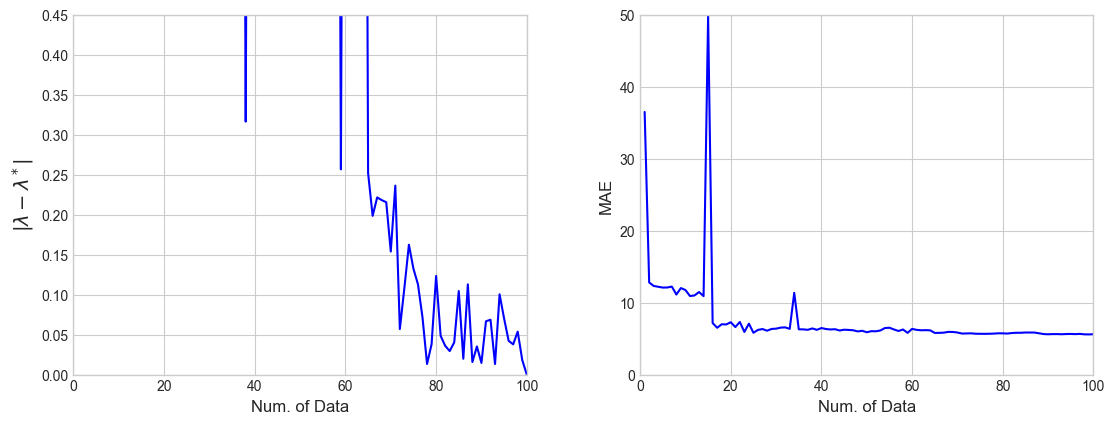


Figure 4 reproduction experiment finished.

--- Starting SIMULATED WiFi Localization Experiment ---
Source (Sim WiFi): X_S (500, 10), y_S (500,)
Target (Sim WiFi) All: X_T_scaled_all (500, 10), y_T (500,)
Target Train: X_T_train (25, 10), y_T_train (25,) (approx 5.0%)
Target Test: X_T_test (475, 10), y_T_test (475,)

--- Training AT-GP Model (Sim WiFi) ---
AT-GP Error Distance (Sim WiFi): 6.1403

--- Training No Transfer GP Model (Sim WiFi) ---
No Transfer GP Error Distance (Sim WiFi): 0.4736

--- Training Transfer All GP Model (Sim WiFi) ---


KeyboardInterrupt: 

In [7]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
from scipy.io import loadmat # Not strictly needed for this problem, but in original code
import pandas as pd # Not strictly needed for this problem, but in original code
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# --- Kernel Function ---
class SquaredExponentialKernel:
    def __init__(self, length_scale=1.0, sigma_f=1.0):
        self.length_scale = length_scale
        self.sigma_f = sigma_f

    def get_params(self):
        return np.array([self.length_scale, self.sigma_f])

    def set_params(self, params):
        self.length_scale = params[0]
        self.sigma_f = params[1]

    def __call__(self, X1, X2):
        if X1.ndim == 1: X1 = X1[:, np.newaxis]
        if X2.ndim == 1: X2 = X2[:, np.newaxis]

        if X1.shape[1] != X2.shape[1]:
            raise ValueError(f"X1 and X2 must have the same number of features. Got {X1.shape[1]} and {X2.shape[1]}")

        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        sqdist = np.clip(sqdist, 0, np.inf) # Ensure non-negative

        return self.sigma_f**2 * np.exp(-0.5 / self.length_scale**2 * sqdist)

# Helper to compute covariance matrix
def calculate_covariance_matrix(X1, X2, kernel_func):
    return kernel_func(X1, X2)

# --- Metrics ---
def nmse(y_true, y_pred):
    y_true_v = np.asarray(y_true).flatten()
    y_pred_v = np.asarray(y_pred).flatten()
    if len(y_true_v) == 0 or len(y_pred_v) == 0: return np.nan
    mse = np.mean((y_true_v - y_pred_v)**2)
    var_true = np.var(y_true_v)
    if var_true < 1e-9: # Avoid division by zero if true values are constant
        return mse if mse > 1e-9 else 0.0
    return mse / var_true

def error_distance(y_true, y_pred): # This is MAE for 1D output, or mean Euclidean for multi-output
    y_true_v = np.asarray(y_true)
    y_pred_v = np.asarray(y_pred)
    if y_true_v.ndim == 1: y_true_v = y_true_v.reshape(-1,1)
    if y_pred_v.ndim == 1: y_pred_v = y_pred_v.reshape(-1,1)

    if y_true_v.shape[0] == 0 or y_pred_v.shape[0] == 0: return np.nan
    # For 1D output, this is equivalent to MAE np.mean(np.abs(y_true_v.ravel() - y_pred_v.ravel()))
    return np.mean(np.sqrt(np.sum((y_true_v - y_pred_v)**2, axis=1)))


def mae(y_true, y_pred):
    y_true_v = np.asarray(y_true).flatten()
    y_pred_v = np.asarray(y_pred).flatten()
    if len(y_true_v) == 0 or len(y_pred_v) == 0: return np.nan
    return np.mean(np.abs(y_true_v - y_pred_v))

# --- AT-GP Model (from paper) ---
class ATGP:
    def __init__(self, X_S, y_S, X_T, y_T,
                 initial_length_scale=1.0, initial_sigma_f=1.0,
                 initial_b=1.0, initial_mu=1.0,
                 initial_noise_S_std=0.1, initial_noise_T_std=0.1):
        self.X_S = X_S
        self.y_S = y_S.reshape(-1, 1)
        self.X_T = X_T
        self.y_T = y_T.reshape(-1, 1)

        self._length_scale = initial_length_scale
        self._sigma_f = initial_sigma_f
        self._b = initial_b
        self._mu = initial_mu
        self._noise_S_std = initial_noise_S_std
        self._noise_T_std = initial_noise_T_std

        self.base_kernel = SquaredExponentialKernel(self._length_scale, self._sigma_f)
        self.fitted = False
        self.optimized_params_ = {}

    def _get_params_array(self):
        return np.array([self._length_scale, self._sigma_f, self._b, self._mu,
                         self._noise_S_std, self._noise_T_std])

    def _set_params_from_array(self, params_array):
        self._length_scale = params_array[0]
        self._sigma_f = params_array[1]
        self.base_kernel.set_params(params_array[:2])
        self._b = params_array[2]
        self._mu = params_array[3]
        self._noise_S_std = params_array[4]
        self._noise_T_std = params_array[5]

    def _get_lambda(self, b_param=None, mu_param=None):
        b_to_use = b_param if b_param is not None else self._b
        mu_to_use = mu_param if mu_param is not None else self._mu
        
        b_to_use = max(1e-5, b_to_use) 
        mu_to_use = max(1e-5, mu_to_use) 

        term_base = 1.0 / (1.0 + mu_to_use) 
        lambda_val = -1.0
        
        try:
            pow_term = np.power(term_base, b_to_use)
            lambda_val = 2 * pow_term - 1
        except (OverflowError, ValueError): 
             lambda_val = np.sign(2 * (0.5 if term_base > 1 else 0) -1) * 1.0 

        return np.clip(lambda_val, -1.0, 1.0)


    def log_marginal_likelihood_conditional(self, params_array_opt):
        params_array_opt = np.maximum(params_array_opt, 1e-5) 

        if self.y_T.shape[0] == 0: 
            return -np.inf

        current_length_scale = params_array_opt[0]
        current_sigma_f = params_array_opt[1]
        temp_kernel = SquaredExponentialKernel(current_length_scale, current_sigma_f)

        current_b = params_array_opt[2]
        current_mu = params_array_opt[3] 
        temp_lambda = self._get_lambda(b_param=current_b, mu_param=current_mu)

        current_noise_S_var = params_array_opt[4]**2
        current_noise_T_var = params_array_opt[5]**2

        jitter = 1e-7 

        K11 = calculate_covariance_matrix(self.X_S, self.X_S, temp_kernel)
        K22 = calculate_covariance_matrix(self.X_T, self.X_T, temp_kernel)
        K_TS_base = calculate_covariance_matrix(self.X_T, self.X_S, temp_kernel) 

        K21 = temp_lambda * K_TS_base 
        K12 = K21.T 

        try:
            K11_noisy = K11 + current_noise_S_var * np.eye(K11.shape[0]) + jitter * np.eye(K11.shape[0])
            L_K11_noisy = np.linalg.cholesky(K11_noisy)
            
            K11_noisy_inv_yS = scipy.linalg.solve_triangular(L_K11_noisy.T, 
                                   scipy.linalg.solve_triangular(L_K11_noisy, self.y_S, lower=True, check_finite=False), 
                                   lower=False, check_finite=False)
            mu_t = K21 @ K11_noisy_inv_yS

            K11_noisy_inv_K12 = scipy.linalg.solve_triangular(L_K11_noisy.T, 
                                    scipy.linalg.solve_triangular(L_K11_noisy, K12, lower=True, check_finite=False), 
                                    lower=False, check_finite=False)

            C_t_main_term = K22 - K21 @ K11_noisy_inv_K12
            C_t = C_t_main_term + current_noise_T_var * np.eye(K22.shape[0]) + jitter * np.eye(K22.shape[0])

            L_Ct = np.linalg.cholesky(C_t)
            log_det_Ct = 2 * np.sum(np.log(np.diag(L_Ct)))

            y_T_minus_mu_t = self.y_T - mu_t
            Ct_inv_y_minus_mu = scipy.linalg.solve_triangular(L_Ct.T, 
                                    scipy.linalg.solve_triangular(L_Ct, y_T_minus_mu_t, lower=True, check_finite=False),
                                    lower=False, check_finite=False)
            
            term2_quadratic = y_T_minus_mu_t.T @ Ct_inv_y_minus_mu
        except np.linalg.LinAlgError:
            return -np.inf 
        
        log_likelihood = -0.5 * log_det_Ct - 0.5 * term2_quadratic - len(self.y_T)/2.0 * np.log(2 * np.pi)

        if np.isnan(log_likelihood) or not np.isfinite(log_likelihood):
            return -np.inf
        return log_likelihood.item()

    def fit(self, method='L-BFGS-B', disp=False, maxiter=200):
        if self.X_T.shape[0] == 0:
            if disp: print("  AT-GP: Cannot fit with zero target data points. Using initial parameters.")
            self.fitted = True 
            self.optimized_params_ = dict(zip(['ls', 'sf', 'b', 'mu', 'noise_S_std', 'noise_T_std', 'lambda_val'],
                                       list(np.round(self._get_params_array(),4)) + [np.round(self._get_lambda(),4)]))
            return None

        initial_params = self._get_params_array()
        if disp:
            print("  Starting AT-GP optimization...")
            print(f"    Initial AT-GP params (ls, sf, b, mu, noise_S_std, noise_T_std): {np.round(initial_params,3)}")
            print(f"    Initial AT-GP lambda: {self._get_lambda():.3f}")

        bounds = [
            (1e-5, 1e3), (1e-5, 1e3), (1e-5, 1e2), (1e-5, 1e2),
            (1e-5, 1e2), (1e-5, 1e2)  
        ]

        objective = lambda params_opt: -self.log_marginal_likelihood_conditional(params_opt)

        result = minimize(objective, initial_params, method=method, bounds=bounds, 
                          options={'disp': disp, 'maxiter': maxiter, 'ftol': 1e-7, 'gtol': 1e-5})

        if disp:
            print("  AT-GP optimization finished.")
            if result:
                print(f"    Success: {result.success}, Message: {result.message}")
                print(f"    Optimized AT-GP params (ls, sf, b, mu, noise_S_std, noise_T_std): {np.round(result.x,3)}")

        self._set_params_from_array(result.x if result else initial_params)
        self.fitted = True
        self.optimized_params_ = dict(zip(['ls', 'sf', 'b', 'mu', 'noise_S_std', 'noise_T_std', 'lambda_val'],
                                       list(np.round(result.x if result else initial_params,4)) + [np.round(self._get_lambda(),4)]))
        if disp:
             print(f"    Optimized AT-GP lambda: {self._get_lambda():.3f}")
        
        if result and not result.success and "CONVERGENCE" not in result.message.upper():
             if disp:
                print(f"    Warning: AT-GP Optimization may not have fully converged: {result.message}")
           
        return result

    def predict(self, X_star_T): 
        if not self.fitted :
             pass # Allow prediction with initial params if not fitted

        lambda_val = self._get_lambda()
        noise_S_var_val = self._noise_S_std**2
        noise_T_var_val = self._noise_T_std**2 
        jitter = 1e-7

        N_S = self.X_S.shape[0]
        N_T = self.X_T.shape[0]
        N_all = N_S + N_T
        
        y_all = np.vstack((self.y_S, self.y_T)) if N_T > 0 else self.y_S 

        K_SS = calculate_covariance_matrix(self.X_S, self.X_S, self.base_kernel)
        
        if N_T > 0:
            K_TT = calculate_covariance_matrix(self.X_T, self.X_T, self.base_kernel)
            K_ST_base = calculate_covariance_matrix(self.X_S, self.X_T, self.base_kernel) 

            K_tilde = np.zeros((N_all, N_all))
            K_tilde[:N_S, :N_S] = K_SS
            K_tilde[N_S:, N_S:] = K_TT
            K_tilde[:N_S, N_S:] = lambda_val * K_ST_base
            K_tilde[N_S:, :N_S] = lambda_val * K_ST_base.T
            
            Big_Lambda_diag = np.concatenate([np.full(N_S, noise_S_var_val),
                                              np.full(N_T, noise_T_var_val)])
        else: # N_T == 0
            K_tilde = K_SS
            Big_Lambda_diag = np.full(N_S, noise_S_var_val)

        Big_Lambda = np.diag(Big_Lambda_diag)
        C_tilde = K_tilde + Big_Lambda + jitter * np.eye(K_tilde.shape[0]) # Use K_tilde.shape[0] for N_all or N_S
        L_Ctilde = None
        try:
            L_Ctilde = np.linalg.cholesky(C_tilde)
            alpha = scipy.linalg.solve_triangular(L_Ctilde.T, 
                        scipy.linalg.solve_triangular(L_Ctilde, y_all, lower=True, check_finite=False), 
                        lower=False, check_finite=False)
        except np.linalg.LinAlgError:
            C_tilde_inv = np.linalg.pinv(C_tilde)
            alpha = C_tilde_inv @ y_all

        k_star_S_base = calculate_covariance_matrix(X_star_T, self.X_S, self.base_kernel) 
        
        if N_T > 0:
            k_star_T_base = calculate_covariance_matrix(X_star_T, self.X_T, self.base_kernel) 
            k_x_star_rows = np.hstack((lambda_val * k_star_S_base, k_star_T_base)) 
        else: # N_T == 0
            k_x_star_rows = lambda_val * k_star_S_base

        mean_star = k_x_star_rows @ alpha 

        k_star_star_diag = np.diag(self.base_kernel(X_star_T, X_star_T))
        c_diag = k_star_star_diag + noise_T_var_val 

        if L_Ctilde is not None:
            v = scipy.linalg.solve_triangular(L_Ctilde, k_x_star_rows.T, lower=True, check_finite=False)
            var_reduction_diag = np.sum(v**2, axis=0) 
        else: 
            var_reduction_diag = np.diag(k_x_star_rows @ C_tilde_inv @ k_x_star_rows.T)

        variance_star_diag = c_diag - var_reduction_diag
        variance_star_diag = np.clip(variance_star_diag, jitter, np.inf) 

        return mean_star, variance_star_diag.reshape(-1,1)


# --- Simple GPR for Baselines ---
class SimpleGPR:
    def __init__(self, initial_length_scale=1.0, initial_sigma_f=1.0, initial_noise_std=0.1):
        self._length_scale = initial_length_scale
        self._sigma_f = initial_sigma_f
        self._noise_std = initial_noise_std
        self.kernel = SquaredExponentialKernel(self._length_scale, self._sigma_f)
        self.X_train, self.y_train, self.alpha_, self.L_ = None, None, None, None
        self.fitted = False
        self.optimized_params_ = {}


    def _get_params_array(self):
        return np.array([self._length_scale, self._sigma_f, self._noise_std])

    def _set_params_from_array(self, params_array):
        self._length_scale = params_array[0]
        self._sigma_f = params_array[1]
        self.kernel.set_params(params_array[:2])
        self._noise_std = params_array[2]

    def log_marginal_likelihood(self, params_array_opt, X, y):
        params_array_opt = np.maximum(params_array_opt, 1e-5) 
        current_length_scale, current_sigma_f = params_array_opt[0], params_array_opt[1]
        temp_kernel = SquaredExponentialKernel(current_length_scale, current_sigma_f)
        current_noise_var = params_array_opt[2]**2
        jitter = 1e-7

        N = X.shape[0]
        if N == 0: return -np.inf 
        K = calculate_covariance_matrix(X, X, temp_kernel)
        K_noisy = K + current_noise_var * np.eye(N) + jitter * np.eye(N)

        try:
            L = np.linalg.cholesky(K_noisy)
            alpha_solve = scipy.linalg.solve_triangular(L.T, 
                                scipy.linalg.solve_triangular(L, y, lower=True, check_finite=False), 
                                lower=False, check_finite=False)
            log_det_K_noisy = 2 * np.sum(np.log(np.diag(L)))
        except np.linalg.LinAlgError: 
            return -np.inf

        lml = -0.5 * y.T @ alpha_solve - 0.5 * log_det_K_noisy - N/2.0 * np.log(2 * np.pi)
        if np.isnan(lml) or not np.isfinite(lml): return -np.inf
        return lml.item()

    def fit(self, X_train, y_train, method='L-BFGS-B', disp=False, maxiter=100, model_name_for_print="SimpleGPR"):
        self.X_train = X_train
        self.y_train = y_train.reshape(-1,1)

        if self.X_train.shape[0] == 0:
            if disp: print(f"  {model_name_for_print}: Cannot fit with zero training data points.")
            self.fitted = False 
            return None


        initial_params = self._get_params_array()
        if disp:
            print(f"  Starting {model_name_for_print} optimization...")
            print(f"    Initial params (ls, sf, noise_std): {np.round(initial_params,3)}")

        bounds = [(1e-5, 1e3), (1e-5, 1e3), (1e-5, 1e2)] 

        objective = lambda params_opt: -self.log_marginal_likelihood(params_opt, self.X_train, self.y_train)
        result = minimize(objective, initial_params, method=method, bounds=bounds, 
                          options={'disp': disp, 'maxiter': maxiter, 'ftol': 1e-7, 'gtol': 1e-5})

        if disp:
            print(f"  {model_name_for_print} optimization finished.")
            print(f"    Success: {result.success}, Message: {result.message}")
            print(f"    Optimized params (ls, sf, noise_std): {np.round(result.x,3)}")

        self._set_params_from_array(result.x)
        self.optimized_params_ = dict(zip(['ls', 'sf', 'noise_std'], np.round(result.x,4)))

        K_final = self.kernel(self.X_train, self.X_train)
        K_noisy_final = K_final + (self._noise_std**2) * np.eye(self.X_train.shape[0]) + 1e-7 * np.eye(self.X_train.shape[0])
        try:
            self.L_ = np.linalg.cholesky(K_noisy_final)
            self.alpha_ = scipy.linalg.solve_triangular(self.L_.T, 
                            scipy.linalg.solve_triangular(self.L_, self.y_train, lower=True, check_finite=False), 
                            lower=False, check_finite=False)
            self.fitted = True
        except np.linalg.LinAlgError:
            if disp:
                print(f"    Warning: Cholesky failed in {model_name_for_print} fit post-optimization. Using PINV for prediction.")
            K_noisy_inv = np.linalg.pinv(K_noisy_final)
            self.alpha_ = K_noisy_inv @ self.y_train
            self.L_ = None 
            self.fitted = True 
        return result

    def predict(self, X_star):
        if not self.fitted: raise RuntimeError("SimpleGPR must be fitted before prediction.")
        if X_star.shape[0] == 0: return np.array([]), np.array([])
        
        if self.X_train.shape[0] == 0: 
            k_star_star_diag = np.diag(self.kernel(X_star, X_star))
            return np.zeros((X_star.shape[0], 1)), (k_star_star_diag + self._noise_std**2).reshape(-1,1)


        jitter = 1e-9

        K_star = self.kernel(X_star, self.X_train) 
        mean_star = K_star @ self.alpha_
        
        K_star_star_diag = np.diag(self.kernel(X_star, X_star)) 
        
        if self.L_ is not None: 
            v = scipy.linalg.solve_triangular(self.L_, K_star.T, lower=True, check_finite=False)
            var_reduction_diag = np.sum(v**2, axis=0)
        else: 
            K_noisy = self.kernel(self.X_train, self.X_train) + \
                      (self._noise_std**2) * np.eye(self.X_train.shape[0]) + \
                      1e-7 * np.eye(self.X_train.shape[0])
            K_noisy_inv = np.linalg.pinv(K_noisy)
            var_reduction_diag = np.diag(K_star @ K_noisy_inv @ K_star.T)

        variance_star_diag = K_star_star_diag + (self._noise_std**2) - var_reduction_diag
        variance_star_diag = np.clip(variance_star_diag, jitter, np.inf) 

        return mean_star, variance_star_diag.reshape(-1,1)


# --- FIGURE 4 REPRODUCTION EXPERIMENT ---
def run_figure4_experiment(seed=42, verbose_optimization=False, Df_strength_fig4=10.0):
    print(f"\n--- Starting Figure 4 Reproduction Experiment (Df={Df_strength_fig4}) ---")
    rng = np.random.RandomState(seed)

    n_features = 1
    n_source_samples = 100
    max_target_train_samples = 100 
    n_target_test_samples = 50     
    
    constant_offset_target = 0.5
    noise_std_data = 0.1

    global_min_y_for_scaling_fig4 = -0.21723362821122155 
    global_max_y_for_scaling_fig4 = 1.0 + constant_offset_target 
    
    def scale_y_to_100(y_vals):
        return (y_vals - global_min_y_for_scaling_fig4) / \
               (global_max_y_for_scaling_fig4 - global_min_y_for_scaling_fig4) * 100

    scaled_noise_estimate_fig4 = noise_std_data * 100 / (global_max_y_for_scaling_fig4 - global_min_y_for_scaling_fig4)

    X_S_raw = rng.uniform(-15, -5, size=(n_source_samples, n_features))
    y_S_unscaled = np.sinc(X_S_raw) + rng.randn(n_source_samples, n_features) * noise_std_data
    y_S_scaled_flat = scale_y_to_100(y_S_unscaled.ravel())

    total_target_samples_needed = max_target_train_samples + n_target_test_samples
    X_T_overall_pool_raw = rng.uniform(5, 15, size=(total_target_samples_needed, n_features))
    y_T_overall_pool_unscaled = np.sinc(X_T_overall_pool_raw - Df_strength_fig4) + constant_offset_target + \
                                rng.randn(total_target_samples_needed, n_features) * noise_std_data
    y_T_overall_pool_scaled_flat = scale_y_to_100(y_T_overall_pool_unscaled.ravel())

    X_T_train_pool_raw = X_T_overall_pool_raw[:max_target_train_samples]
    y_T_train_pool_scaled_flat = y_T_overall_pool_scaled_flat[:max_target_train_samples]
    X_T_test_raw = X_T_overall_pool_raw[max_target_train_samples:]
    y_T_test_scaled_flat = y_T_overall_pool_scaled_flat[max_target_train_samples:]

    scaler_S = StandardScaler()
    X_S = scaler_S.fit_transform(X_S_raw)

    scaler_T_pool = StandardScaler()
    X_T_train_pool_scaled = scaler_T_pool.fit_transform(X_T_train_pool_raw)
    X_T_test_scaled = scaler_T_pool.transform(X_T_test_raw) 

    default_ls = 1.0
    default_sf = 10.0 
    default_noise_gp = max(1.0, scaled_noise_estimate_fig4)
    default_b, default_mu = 1.0, 1.0 
    max_iter_fit = 50 

    print("  Determining lambda_star using all target training data...")
    atgp_model_for_lambda_star = ATGP(X_S, y_S_scaled_flat, 
                                      X_T_train_pool_scaled, y_T_train_pool_scaled_flat,
                                      initial_length_scale=default_ls, initial_sigma_f=default_sf,
                                      initial_b=default_b, initial_mu=default_mu,
                                      initial_noise_S_std=default_noise_gp, 
                                      initial_noise_T_std=default_noise_gp)
    atgp_model_for_lambda_star.fit(disp=verbose_optimization, maxiter=max_iter_fit)
    lambda_star = atgp_model_for_lambda_star._get_lambda()
    print(f"  Determined lambda_star = {lambda_star:.4f} (using {max_target_train_samples} target samples)")
    if verbose_optimization:
        print(f"    Params for lambda_star: {atgp_model_for_lambda_star.optimized_params_}")


    num_data_values = np.arange(1, max_target_train_samples + 1)
    lambda_diffs = []
    maes_on_test = []

    for i, n_t_current in enumerate(num_data_values):
        if (i + 1) % 10 == 0 or i == 0 : 
             print(f"  Processing with n_t_current = {n_t_current}/{max_target_train_samples}")
        
        X_T_train_iter = X_T_train_pool_scaled[:n_t_current]
        y_T_train_iter_flat = y_T_train_pool_scaled_flat[:n_t_current]

        atgp_iter_model = ATGP(X_S, y_S_scaled_flat, X_T_train_iter, y_T_train_iter_flat,
                               initial_length_scale=default_ls, initial_sigma_f=default_sf,
                               initial_b=default_b, initial_mu=default_mu,
                               initial_noise_S_std=default_noise_gp, 
                               initial_noise_T_std=default_noise_gp)
        
        atgp_iter_model.fit(disp=False, maxiter=max_iter_fit) 
        
        current_lambda = atgp_iter_model._get_lambda()
        lambda_diffs.append(np.abs(current_lambda - lambda_star))
        
        mean_pred_test, _ = atgp_iter_model.predict(X_T_test_scaled)
        mae_test = mae(y_T_test_scaled_flat, mean_pred_test)
        maes_on_test.append(mae_test)

        if verbose_optimization and ( (i + 1) % 20 == 0 or i == 0): 
            print(f"    n_t={n_t_current}: Lambda={current_lambda:.3f}, |L-L*|={lambda_diffs[-1]:.3f}, MAE={mae_test:.3f}")


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

    axs[0].plot(num_data_values, lambda_diffs, 'b-', linewidth=1.5)
    axs[0].set_xlabel('Num. of Data', fontsize=12)
    axs[0].set_ylabel('$|\\lambda - \\lambda^*|$', fontsize=14)
    axs[0].set_ylim(0, 0.45) 
    axs[0].set_xlim(0, max_target_train_samples)
    axs[0].tick_params(axis='both', which='major', labelsize=10)


    axs[1].plot(num_data_values, maes_on_test, 'b-', linewidth=1.5)
    axs[1].set_xlabel('Num. of Data', fontsize=12)
    axs[1].set_ylabel('MAE', fontsize=12)
    axs[1].set_ylim(0, 50) 
    axs[1].set_xlim(0, max_target_train_samples)
    axs[1].tick_params(axis='both', which='major', labelsize=10)
    
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.18, top=0.90, wspace=0.25)
    plt.show()

    return num_data_values, lambda_diffs, maes_on_test

def run_wine_experiment(verbose_optimization, seed):
    print("\n--- Starting WINE Dataset Experiment ---")
    try:
        wine_white_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
        wine_red_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
    except Exception as e:
        print(f"Failed to load wine datasets: {e}. Skipping WINE experiment.")
        return None

    X_S_raw = wine_white_df.drop('quality', axis=1).values
    y_S_raw = wine_white_df['quality'].values
    X_T_raw = wine_red_df.drop('quality', axis=1).values
    y_T_raw = wine_red_df['quality'].values

    scaler_S = StandardScaler()
    X_S = scaler_S.fit_transform(X_S_raw)

    scaler_T_all_wine = StandardScaler()
    X_T_scaled_all = scaler_T_all_wine.fit_transform(X_T_raw)

    X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(
        X_T_scaled_all, y_T_raw, train_size=0.05, random_state=seed
    )
    
    if X_T_train.shape[0] < 2:
        print("Not enough target training samples for WINE after split. Skipping.")
        return None


    print(f"Source (White Wine): X_S {X_S.shape}, y_S {y_S_raw.shape}")
    print(f"Target (Red Wine) All: X_T_scaled_all {X_T_scaled_all.shape}, y_T {y_T_raw.shape}")
    print(f"Target Train: X_T_train {X_T_train.shape}, y_T_train {y_T_train.shape} (approx {X_T_train.shape[0]/X_T_raw.shape[0]*100:.1f}%)")
    print(f"Target Test: X_T_test {X_T_test.shape}, y_T_test {y_T_test.shape}")

    results = {}
    default_ls, default_sf, default_noise = 1.0, 1.0, 0.5
    default_b, default_mu = 1.0, 1.0 

    print("\n--- Training AT-GP Model (Wine) ---")
    atgp_model = ATGP(X_S, y_S_raw, X_T_train, y_T_train,
                      initial_length_scale=default_ls, initial_sigma_f=default_sf,
                      initial_b=default_b, initial_mu=default_mu,
                      initial_noise_S_std=default_noise, initial_noise_T_std=default_noise)
    atgp_model.fit(disp=verbose_optimization, maxiter=100)
    mean_atgp, _ = atgp_model.predict(X_T_test)
    results['AT-GP'] = nmse(y_T_test, mean_atgp)
    print(f"AT-GP NMSE (Wine): {results['AT-GP']:.4f}")

    print("\n--- Training No Transfer GP Model (Wine) ---")
    gp_no_transfer = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_no_transfer.fit(X_T_train, y_T_train, disp=verbose_optimization, maxiter=100, model_name_for_print="No Transfer GP (Wine)")
    if gp_no_transfer.fitted:
        mean_no_transfer, _ = gp_no_transfer.predict(X_T_test)
        results['No Transfer GP'] = nmse(y_T_test, mean_no_transfer)
        print(f"No Transfer GP NMSE (Wine): {results['No Transfer GP']:.4f}")
    else:
        results['No Transfer GP'] = np.nan
        print(f"No Transfer GP NMSE (Wine): Failed to fit.")


    print("\n--- Training Transfer All GP Model (Wine) ---")
    X_S_rescaled_for_All = scaler_T_all_wine.transform(scaler_S.inverse_transform(X_S))
    X_all_train = np.vstack((X_S_rescaled_for_All, X_T_train))
    y_all_train = np.concatenate((y_S_raw, y_T_train))

    gp_transfer_all = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_transfer_all.fit(X_all_train, y_all_train, disp=verbose_optimization, maxiter=100, model_name_for_print="Transfer All GP (Wine)")
    if gp_transfer_all.fitted:
        mean_transfer_all, _ = gp_transfer_all.predict(X_T_test)
        results['Transfer All GP'] = nmse(y_T_test, mean_transfer_all)
        print(f"Transfer All GP NMSE (Wine): {results['Transfer All GP']:.4f}")
    else:
        results['Transfer All GP'] = np.nan
        print(f"Transfer All GP NMSE (Wine): Failed to fit.")


    print("\n--- Summary of NMSE Results on WINE Dataset ---")
    for model_name, score in results.items():
        print(f"{model_name}: {score:.4f}")
    return results


def run_sarcos_experiment(verbose_optimization, seed):
    print("\n--- Starting SARCOS Dataset Experiment ---")
    try:
        # Users might need to change these paths or download the files
        input_file_path = 'sarcos_inv.mat' 
        output_file_path = 'sarcos_inv_test.mat'

        sarcos_inputs_full = loadmat(input_file_path)['sarcos_inv']  
        sarcos_outputs_full = loadmat(output_file_path)['sarcos_inv_test']

        print(f"Loaded sarcos_inputs_full: {sarcos_inputs_full.shape}")
        print(f"Loaded sarcos_outputs_full: {sarcos_outputs_full.shape}")

        num_common_samples = min(sarcos_inputs_full.shape[0], sarcos_outputs_full.shape[0])

        if num_common_samples == 0:
            print("No common samples found or one of the files is empty. Skipping SARCOS.")
            return None
        
        print(f"Working with {num_common_samples} common samples.")

        sarcos_inputs_matched = sarcos_inputs_full[:num_common_samples, :]
        sarcos_outputs_matched = sarcos_outputs_full[:num_common_samples, :]

        if sarcos_outputs_matched.shape[1] < 2:
            print(f"SARCOS output data has only {sarcos_outputs_matched.shape[1]} joint(s). Need at least 2. Skipping.")
            return None


    except FileNotFoundError:
        print(f"SARCOS .mat files ('{input_file_path}', '{output_file_path}') not found. Please download them or check paths. Skipping SARCOS experiment.")
        return None
    except KeyError as e:
        print(f"KeyError loading SARCOS data: {e}. Make sure the keys ('sarcos_inv', 'sarcos_inv_test') are correct. Skipping SARCOS experiment.")
        return None
    except Exception as e:
        print(f"Error loading SARCOS data: {e}. Skipping SARCOS experiment.")
        return None


    n_source_samples_desired = 1000
    n_target_total_samples_desired = 1000

    if n_source_samples_desired + n_target_total_samples_desired > num_common_samples:
        print(f"Desired samples ({n_source_samples_desired + n_target_total_samples_desired}) exceed available common samples ({num_common_samples}). Adjusting.")
        scale_factor = num_common_samples / (n_source_samples_desired + n_target_total_samples_desired)
        n_source_samples = int(n_source_samples_desired * scale_factor)
        n_target_total_samples = num_common_samples - n_source_samples
        min_target_for_split = 20
        if n_target_total_samples < min_target_for_split and num_common_samples >= n_source_samples + min_target_for_split :
            n_target_total_samples = min_target_for_split
            n_source_samples = num_common_samples - n_target_total_samples
        elif n_target_total_samples < min_target_for_split:
            print(f"Not enough common samples ({num_common_samples}) to satisfy minimum target samples for split. Skipping.")
            return None

        if n_source_samples <= 0 :
            if num_common_samples > n_target_total_samples:
                n_source_samples = num_common_samples - n_target_total_samples
            else:
                print("Cannot allocate source samples. Skipping SARCOS.")
                return None
        print(f"Adjusted: n_source_samples={n_source_samples}, n_target_total_samples={n_target_total_samples}")
    else:
        n_source_samples = n_source_samples_desired
        n_target_total_samples = n_target_total_samples_desired
    
    if n_source_samples <= 0 or n_target_total_samples <= 0:
        print("No samples allocated for source or target after adjustment. Skipping SARCOS.")
        return None

    indices = np.random.RandomState(seed).permutation(num_common_samples)
    
    source_indices_from_perm = indices[:n_source_samples]
    target_indices_from_perm = indices[n_source_samples : n_source_samples + n_target_total_samples]

    X_S_raw = sarcos_inputs_matched[source_indices_from_perm, :]
    y_S_raw = sarcos_outputs_matched[source_indices_from_perm, 0]

    X_T_raw_all = sarcos_inputs_matched[target_indices_from_perm, :]
    y_T_raw_all = sarcos_outputs_matched[target_indices_from_perm, 1]

    scaler_S = StandardScaler()
    X_S = scaler_S.fit_transform(X_S_raw)

    scaler_T_all_sarcos = StandardScaler()
    X_T_scaled_all = scaler_T_all_sarcos.fit_transform(X_T_raw_all)

    if y_T_raw_all.shape[0] < 2:
        print(f"Not enough samples in y_T_raw_all ({y_T_raw_all.shape[0]}) to split. Skipping SARCOS.")
        return None

    train_size_target_actual = 0.05
    num_train_target = int(y_T_raw_all.shape[0] * train_size_target_actual)

    if num_train_target < 2:
        if y_T_raw_all.shape[0] >= 2:
            num_train_target = 2
            train_size_target_actual = num_train_target / y_T_raw_all.shape[0]
        else: 
            print(f"Cannot get 2 training samples from target data of size {y_T_raw_all.shape[0]}. Skipping SARCOS.")
            return None
    
    if y_T_raw_all.shape[0] - num_train_target < 1:
        print(f"Not enough samples for testing after allocating {num_train_target} for training from {y_T_raw_all.shape[0]}. Skipping.")
        return None


    X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(
        X_T_scaled_all, y_T_raw_all, train_size=train_size_target_actual, random_state=seed
    )
    
    if X_T_train.shape[0] < 2: 
        print("Not enough target training samples for SARCOS after split. Skipping.")
        return None

    print(f"Source (SARCOS Joint 1): X_S {X_S.shape}, y_S {y_S_raw.shape}")
    print(f"Target Pool (SARCOS Joint 2): X_T_raw_all {X_T_raw_all.shape}, y_T_raw_all {y_T_raw_all.shape}")
    print(f"Target Train: X_T_train {X_T_train.shape}, y_T_train {y_T_train.shape} (train_size={train_size_target_actual*100:.1f}%)")
    print(f"Target Test: X_T_test {X_T_test.shape}, y_T_test {y_T_test.shape}")

    results = {}
    default_ls, default_sf, default_noise = 1.0, 1.0, 0.1 
    default_b, default_mu = 1.0, 1.0
    max_iter_sarcos = 30 

    print(f"\n--- Training AT-GP Model (SARCOS, max_iter={max_iter_sarcos}) ---")
    atgp_model = ATGP(X_S, y_S_raw, X_T_train, y_T_train,
                      initial_length_scale=default_ls, initial_sigma_f=default_sf,
                      initial_b=default_b, initial_mu=default_mu,
                      initial_noise_S_std=default_noise, initial_noise_T_std=default_noise)
    atgp_model.fit(disp=verbose_optimization, maxiter=max_iter_sarcos)
    mean_atgp, _ = atgp_model.predict(X_T_test)
    results['AT-GP'] = nmse(y_T_test, mean_atgp)
    print(f"AT-GP NMSE (SARCOS): {results['AT-GP']:.4f}")

    print(f"\n--- Training No Transfer GP Model (SARCOS, max_iter={max_iter_sarcos}) ---")
    gp_no_transfer = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_no_transfer.fit(X_T_train, y_T_train, disp=verbose_optimization, maxiter=max_iter_sarcos, model_name_for_print="No Transfer GP (SARCOS)")
    if gp_no_transfer.fitted:
        mean_no_transfer, _ = gp_no_transfer.predict(X_T_test)
        results['No Transfer GP'] = nmse(y_T_test, mean_no_transfer)
        print(f"No Transfer GP NMSE (SARCOS): {results['No Transfer GP']:.4f}")
    else:
        results['No Transfer GP'] = np.nan
        print(f"No Transfer GP NMSE (SARCOS): Failed to fit.")


    print(f"\n--- Training Transfer All GP Model (SARCOS, max_iter={max_iter_sarcos}) ---")
    X_S_rescaled_for_All = scaler_T_all_sarcos.transform(scaler_S.inverse_transform(X_S))
    X_all_train = np.vstack((X_S_rescaled_for_All, X_T_train))
    y_all_train = np.concatenate((y_S_raw, y_T_train))

    gp_transfer_all = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_transfer_all.fit(X_all_train, y_all_train, disp=verbose_optimization, maxiter=max_iter_sarcos, model_name_for_print="Transfer All GP (SARCOS)")
    if gp_transfer_all.fitted:
        mean_transfer_all, _ = gp_transfer_all.predict(X_T_test)
        results['Transfer All GP'] = nmse(y_T_test, mean_transfer_all)
        print(f"Transfer All GP NMSE (SARCOS): {results['Transfer All GP']:.4f}")
    else:
        results['Transfer All GP'] = np.nan
        print(f"Transfer All GP NMSE (SARCOS): Failed to fit.")


    print("\n--- Summary of NMSE Results on SARCOS Dataset ---")
    for model_name, score in results.items():
        print(f"{model_name}: {score:.4f}")
    return results


def run_simulated_wifi_experiment(verbose_optimization, seed):
    print("\n--- Starting SIMULATED WiFi Localization Experiment ---")
    rng = np.random.RandomState(seed)
    n_features = 10
    n_source_samples = 500
    n_target_samples_all = 500 
    
    w_S = rng.randn(n_features, 1)
    X_S_raw = rng.rand(n_source_samples, n_features) * 10
    y_S_raw = X_S_raw @ w_S + rng.randn(n_source_samples, 1) * 0.5 

    delta_w = rng.randn(n_features, 1) * 0.5 
    w_T = w_S + delta_w
    X_T_raw_all = rng.rand(n_target_samples_all, n_features) * 10 + rng.rand(1, n_features) * 2
    y_T_raw_all = X_T_raw_all @ w_T + rng.randn(n_target_samples_all, 1) * 0.5 

    scaler_S = StandardScaler()
    X_S = scaler_S.fit_transform(X_S_raw)

    scaler_T_all_wifi = StandardScaler()
    X_T_scaled_all = scaler_T_all_wifi.fit_transform(X_T_raw_all)

    X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(
        X_T_scaled_all, y_T_raw_all.ravel(), train_size=0.05, random_state=seed
    )
    if X_T_train.shape[0] < 2 :
        print("Not enough target training samples for WiFi Sim after split. Skipping.")
        return None

    print(f"Source (Sim WiFi): X_S {X_S.shape}, y_S {y_S_raw.ravel().shape}")
    print(f"Target (Sim WiFi) All: X_T_scaled_all {X_T_scaled_all.shape}, y_T {y_T_raw_all.ravel().shape}")
    print(f"Target Train: X_T_train {X_T_train.shape}, y_T_train {y_T_train.shape} (approx {X_T_train.shape[0]/X_T_raw_all.shape[0]*100:.1f}%)")
    print(f"Target Test: X_T_test {X_T_test.shape}, y_T_test {y_T_test.shape}")

    results = {}
    default_ls, default_sf, default_noise = 1.0, 1.0, 0.2
    default_b, default_mu = 1.0, 1.0

    print("\n--- Training AT-GP Model (Sim WiFi) ---")
    atgp_model = ATGP(X_S, y_S_raw.ravel(), X_T_train, y_T_train,
                      initial_length_scale=default_ls, initial_sigma_f=default_sf,
                      initial_b=default_b, initial_mu=default_mu,
                      initial_noise_S_std=default_noise, initial_noise_T_std=default_noise)
    atgp_model.fit(disp=verbose_optimization, maxiter=100)
    mean_atgp, _ = atgp_model.predict(X_T_test)
    results['AT-GP'] = error_distance(y_T_test, mean_atgp)
    print(f"AT-GP Error Distance (Sim WiFi): {results['AT-GP']:.4f}")

    print("\n--- Training No Transfer GP Model (Sim WiFi) ---")
    gp_no_transfer = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_no_transfer.fit(X_T_train, y_T_train, disp=verbose_optimization, maxiter=100, model_name_for_print="No Transfer GP (Sim WiFi)")
    if gp_no_transfer.fitted:
        mean_no_transfer, _ = gp_no_transfer.predict(X_T_test)
        results['No Transfer GP'] = error_distance(y_T_test, mean_no_transfer)
        print(f"No Transfer GP Error Distance (Sim WiFi): {results['No Transfer GP']:.4f}")
    else:
        results['No Transfer GP'] = np.nan
        print(f"No Transfer GP Error Distance (Sim WiFi): Failed to fit.")

    print("\n--- Training Transfer All GP Model (Sim WiFi) ---")
    X_S_rescaled_for_All = scaler_T_all_wifi.transform(scaler_S.inverse_transform(X_S))
    X_all_train = np.vstack((X_S_rescaled_for_All, X_T_train))
    y_all_train = np.concatenate((y_S_raw.ravel(), y_T_train))

    gp_transfer_all = SimpleGPR(initial_length_scale=default_ls, initial_sigma_f=default_sf, initial_noise_std=default_noise)
    gp_transfer_all.fit(X_all_train, y_all_train, disp=verbose_optimization, maxiter=100, model_name_for_print="Transfer All GP (Sim WiFi)")
    if gp_transfer_all.fitted:
        mean_transfer_all, _ = gp_transfer_all.predict(X_T_test)
        results['Transfer All GP'] = error_distance(y_T_test, mean_transfer_all)
        print(f"Transfer All GP Error Distance (Sim WiFi): {results['Transfer All GP']:.4f}")
    else:
        results['Transfer All GP'] = np.nan
        print(f"Transfer All GP Error Distance (Sim WiFi): Failed to fit.")

    print("\n--- Summary of Error Distance Results on SIMULATED WiFi Dataset ---")
    for model_name, score in results.items():
        print(f"{model_name}: {score:.4f}")
    return results


if __name__ == '__main__':
    np.set_printoptions(precision=4, suppress=True)
    np.seterr(all='ignore') 
    
    verbose_opt_experiments = False 
    random_seed_experiments = 111

    # Run Figure 4 experiment
    verbose_opt_fig4 = False 
    random_seed_fig4 = 42 
    Df_for_fig4 = 5.0 
    print(f"\nStarting Figure 4 reproduction with seed={random_seed_fig4}, Df={Df_for_fig4}, verbose_optimization={verbose_opt_fig4}")
    results_fig4 = run_figure4_experiment(seed=random_seed_fig4, 
                                          verbose_optimization=verbose_opt_fig4,
                                          Df_strength_fig4=Df_for_fig4)
    print("\nFigure 4 reproduction experiment finished.")

    # Run other experiments
    sim_wifi_results = run_simulated_wifi_experiment(verbose_optimization=verbose_opt_experiments, seed=random_seed_experiments)
    sarcos_results = run_sarcos_experiment(verbose_optimization=verbose_opt_experiments, seed=random_seed_experiments)
    sim_wine_results = run_wine_experiment(verbose_optimization=verbose_opt_experiments, seed=random_seed_experiments)

    print("\n\n--- OVERALL RESULTS SUMMARY ---")
    if sim_wifi_results:
        print("\nSimulated WiFi Dataset (Error Distance):")
        for model, score_val in sim_wifi_results.items(): print(f"  {model}: {score_val:.4f}")
    
    if sarcos_results:
        print("\nSARCOS Dataset (Subsampled, J1->J2, NMSE):")
        for model, score_val in sarcos_results.items(): print(f"  {model}: {score_val:.4f}")

    if sim_wine_results:
        print("\nWine Dataset (NMSE):") # Changed from "Simulated Wine" to "Wine"
        for model, score_val in sim_wine_results.items(): print(f"  {model}: {score_val:.4f}")